# G2G Analysis of Organoid SP T cells vs Type 1 Innate T cells in pan fetal reference

In [1]:
import anndata
import numpy as np
import pandas as pd 
import seaborn as sb
import matplotlib.pyplot as plt
import pickle
import os,sys,inspect
import scanpy as sc

# G2G source imports 
import Main
import MyFunctions 
import TimeSeriesPreprocessor
import PathwayAnalyserV2
import VisualUtils
import ClusterUtils
import VisualUtils

import warnings
warnings.filterwarnings("ignore")
import platform
print(platform.python_version())

(CVXPY) Oct 11 10:38:48 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Oct 11 10:38:48 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
3.9.16


In [2]:
input_dir ='../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/'
adata_ref = anndata.read_h5ad(input_dir+'PanfetalATO_SPT_DNonwards_gplvm_ref_24012023.h5ad')
adata_query = anndata.read_h5ad(input_dir +'PanfetalATO_SPT_DNonwards_gplvm_ATO_24012023.h5ad') 

print(adata_ref.X.data)
print(adata_query.X.data)
print(adata_ref.shape)
print(adata_query.shape)


[1.6558038 1.6558038 1.6558038 ... 0.9572873 0.9572873 0.9572873]
[0.5900355  0.3379185  0.5900355  ... 0.45287    0.25185528 1.0000652 ]
(18436, 17718)
(10089, 17718)


In [3]:
np.mean(adata_query.obs.time)

0.4862739216642682

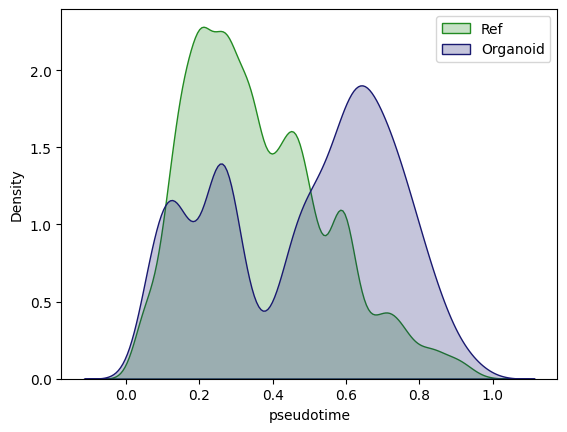

0.0 1.0
0.0 1.0


In [4]:

common_genes = np.intersect1d(adata_ref.var_names, adata_query.var_names)
len(common_genes )
def get_human_TF_list(): 
    # get a human TF list 
    TF_list = pd.read_csv('huamn_TF_list.csv',skiprows=1)
    np.unique(TF_list['Unnamed: 3'], return_counts=True) # There are only 1639 true TFs out of 2765 TFs in this list 
    TF_list = TF_list[TF_list['Unnamed: 3']=='Yes']
    TF_list['Name']
    return TF_list
human_TFs = get_human_TF_list()
human_TFs = np.intersect1d(common_genes , np.asarray(human_TFs['Name']) )
# Examine ref and query pseudotime distributions
sb.kdeplot(adata_ref.obs['time'], fill=True, label='Ref', color='forestgreen') 
sb.kdeplot(adata_query.obs['time'], fill=True, label='Organoid', color='midnightblue'); plt.xlabel('pseudotime'); plt.legend()
plt.show()

print(min(adata_ref.obs['time']), max(adata_ref.obs['time'])) 
print(min(adata_query.obs['time']), max(adata_query.obs['time']))



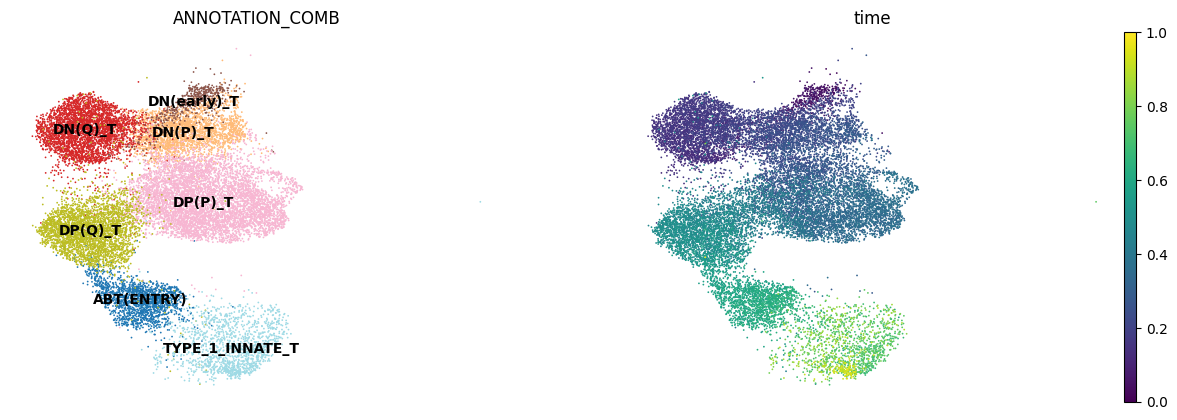

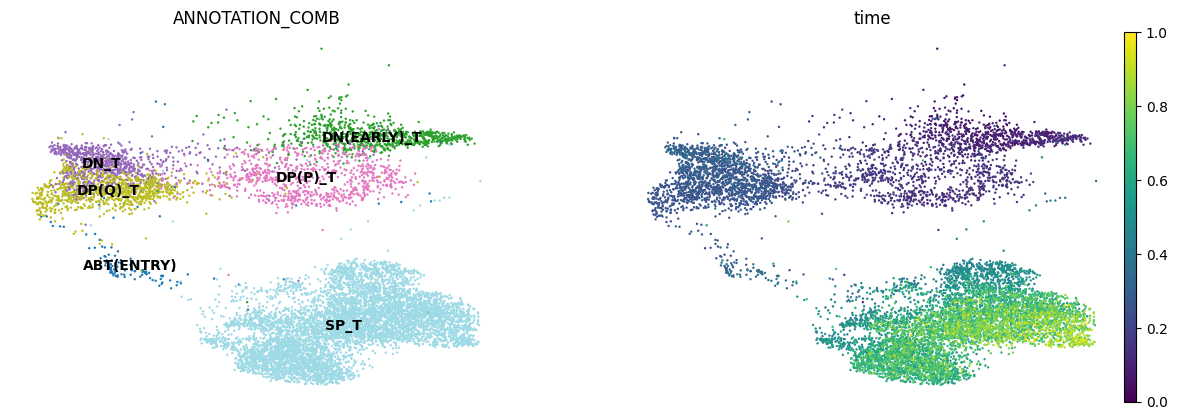

In [6]:
sc.pl.umap(adata_ref, color = ['ANNOTATION_COMB','time'], legend_loc='on data', frameon=False)
sc.pl.umap(adata_query, color = ['ANNOTATION_COMB','time'], legend_loc='on data', frameon=False)

In [5]:
from optbinning import ContinuousOptimalBinning
x = np.asarray(adata_query.obs.time)
optb = ContinuousOptimalBinning(name='pseudotime', dtype="numerical")
optb.fit(x, x)
len(optb.splits)

14

In [6]:
from optbinning import ContinuousOptimalBinning
x = np.asarray(adata_query.obs.time)
optb = ContinuousOptimalBinning(name='pseudotime', dtype="numerical")
optb.fit(x, x)
len(optb.splits)

14

In [7]:
joint_cmap = {'IPSC': '#c7c7c7',
'PRIMITIVE_STREAK': '#9edae5',
'MESODERMAL_PROGENITOR': '#dbdb8d',
'ENDOTHELIUM': '#17becf',
'HSC_MPP': '#f7b6d2',
'HSC_MPP/LMPP_MLP/DC2': '#8c564b',
'LMPP_MLP': '#8c564b',
'CYCLING_MPP': '#e377c2',
'DN(EARLY)_T': '#1f77b4',
'DN(early)_T': '#1f77b4',
'DN_T': '#aec7e8',
'DN(P)_T': '#aec7e8',
'DN(Q)_T': '#ff7f0e',
'DP(P)_T': '#ffbb78',
'DP(Q)_T': '#2ca02c',
'ABT(ENTRY)': '#98df8a',
'SP_T': '#ff9896',
'TYPE_1_INNATE_T': '#c5b0d5'}

# trying max n points for optimal binning = 14
Optimal equal number of bins for R and Q =  14


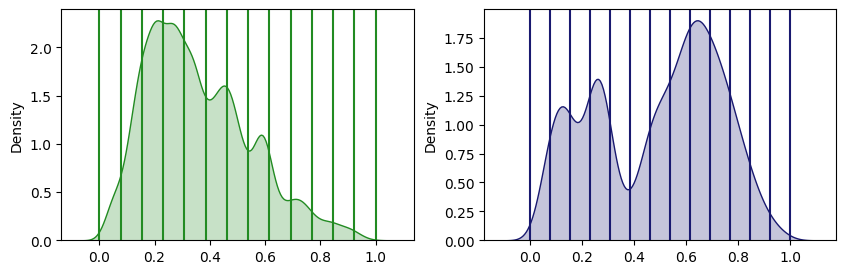

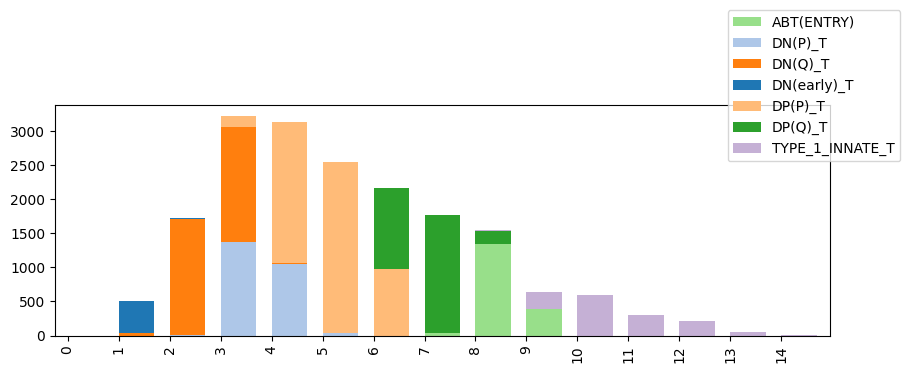

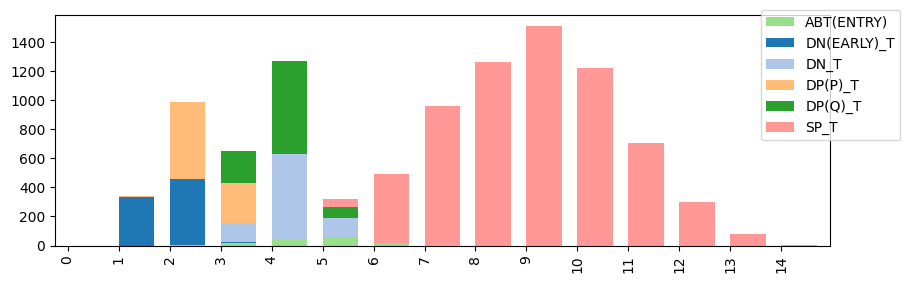

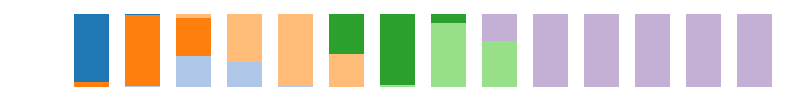

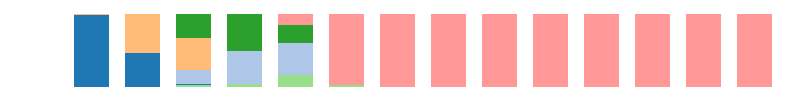

In [8]:
# We find 13 to be the size of the optimal binning
vs = VisualUtils.VisualUtils.get_celltype_composition_across_time(adata_ref, adata_query, 
                                                              n_points=14, ANNOTATION_COLNAME='ANNOTATION_COMB', 
                                                              optimal_binning=False,
                                                             ref_cmap=joint_cmap, query_cmap=joint_cmap, plot_celltype_counts=True)
#vs.metaS.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True,color=joint_cmap, grid = False, legend=False, width=0.7,align='edge',figsize=(10,1))
#plt.axis('off')
#plt.savefig('plots/Fig6/ref_timebins.pdf')
#vs.metaT.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True,color=joint_cmap, grid = False, legend=False, width=0.7,align='edge',figsize=(10,1))
#plt.axis('off')
#plt.savefig('plots/Fig6/ato_timebins.pdf')

In [9]:
# RUN G2G ALIGNMENT

gene_list = human_TFs
aligner = Main.RefQueryAligner(adata_ref, adata_query, gene_list, len(vs.optimal_bining_S))
aligner.WEIGHT_BY_CELL_DENSITY = True
aligner.WINDOW_SIZE=0.1
aligner.state_params = [0.99,0.1,0.7]
aligner.optimal_binning = True
aligner.opt_binning_S = vs.optimal_bining_S
aligner.opt_binning_T = vs.optimal_bining_T
aligner.align_all_pairs()
#pickle.dump(aligner, open('../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/aligner_TF_SPTDNonwards.pkl', 'wb')) 


WINDOW_SIZE= 0.1


  0%|          | 0/1220 [00:00<?, ?it/s]

In [13]:
#pickle.dump(aligner, open('../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/FinalResults/aligner_TF_SPTDNonwards.pkl', 'wb')) 

In [9]:
with open('../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/FinalResults/aligner_TF_SPTDNonwards.pkl', 'rb') as f:
    aligner = pickle.load(f)

Average Alignment:  MMMMMMMMIMMVMIDDD


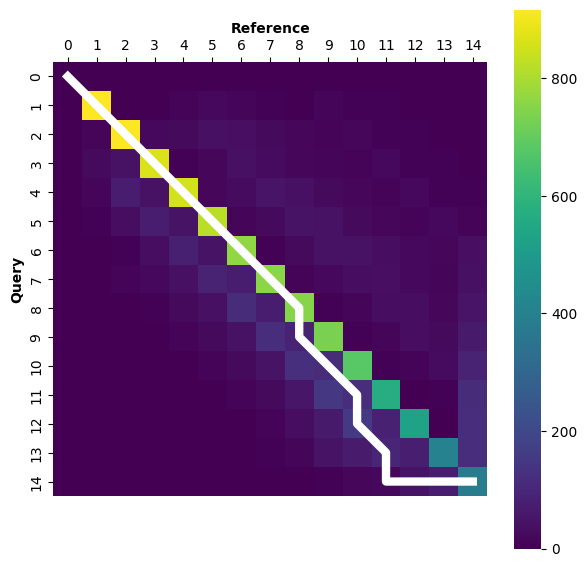

In [8]:
aligner.get_aggregate_alignment()
#plt.savefig('MS_FIGS/RefATO/MoreFigs/average_TF_alignment_forDNonwards_spt.png')

In [32]:
#pickle.dump(aligner, open('../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/aligner_TF_SPTDNonwards.pkl', 'wb')) 

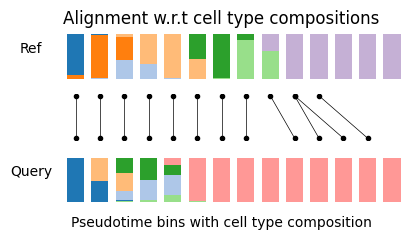

In [12]:
vs.visualize_gene_alignment("MMMMMMMMIMMVMIDDD", cmap=joint_cmap)
plt.savefig('MS_FIGS/RefATO/MoreFigs/average_TF_alignment_SPT_illustration.pdf')

In [10]:
len(aligner.gene_list)

1220

mean matched percentage: 
72.53 %


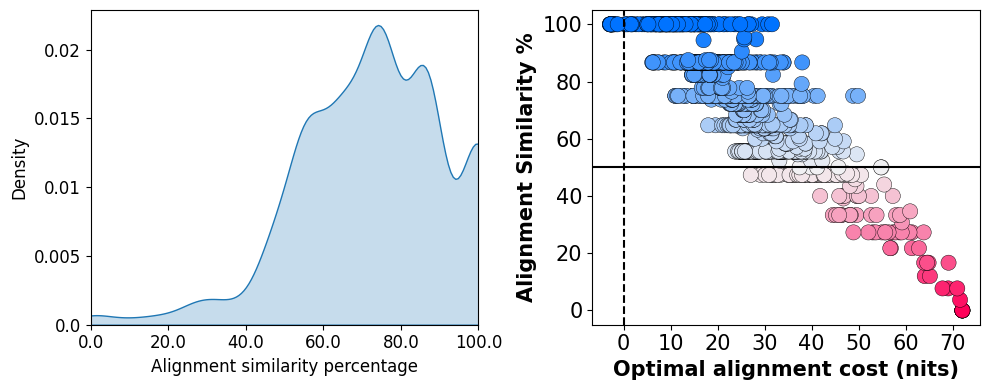

In [11]:
df = aligner.get_stat_df() 

In [12]:
# selecting reasonable thresholds by manual inspection to identify top/highly distant genes
# this call might sometime gives 'error sending list' from GSEAPy package function call -
#topDEgenes = df[np.logical_and(list(df['opt_alignment_cost'] >=50), list(df['alignment_similarity_percentage'] <=0.5))]['Gene']
topDEgenes = df[list(df['alignment_similarity_percentage'] <=0.4)]['Gene']
pathway_df = PathwayAnalyserV2.run_overrepresentation_analysis(topDEgenes) # this is a wrapper function call for GSEAPy enrichr inferface
pathway_df

Gene_set                                               Term  \
0   MSigDB_Hallmark_2020                      TNF-alpha Signaling via NF-kB   
1   MSigDB_Hallmark_2020                                        p53 Pathway   
2   MSigDB_Hallmark_2020                                     UV Response Up   
3   MSigDB_Hallmark_2020                                            Hypoxia   
4   MSigDB_Hallmark_2020                                    G2-M Checkpoint   
31       KEGG_2021_Human            Human T-cell leukemia virus 1 infection   
30       KEGG_2021_Human                         Osteoclast differentiation   
32       KEGG_2021_Human                                          Pertussis   
34       KEGG_2021_Human                   Th1 and Th2 cell differentiation   
35       KEGG_2021_Human                            IL-17 signaling pathway   
33       KEGG_2021_Human                                        Hepatitis B   
36       KEGG_2021_Human    Kaposi sarcoma-associated herpesvirus infection   
37       KEGG_2021_Human                          Th17 cell differentiation   
38       KEGG_2021_Human                              TNF signaling pathway   
39       KEGG_2021_Human                                  Cocaine addiction   
40       KEGG_2021_Human                            Chemical carcinogenesis   
41       KEGG_2021_Human             Fluid shear stress and atherosclerosis   
44       KEGG_2021_Human                                          Mitophagy   
45       KEGG_2021_Human                              Amphetamine addiction   
43       KEGG_2021_Human                                      Breast cancer   
42       KEGG_2021_Human                         Inflammatory bowel disease   
46       KEGG_2021_Human                                Cellular senescence   
47       KEGG_2021_Human                                      Leishmaniasis   
48       KEGG_2021_Human                  B cell receptor signaling pathway   
49       KEGG_2021_Human                                  Colorectal cancer   
50       KEGG_2021_Human  PD-L1 expression and PD-1 checkpoint pathway i...   
6   MSigDB_Hallmark_2020                                  KRAS Signaling Up   
5   MSigDB_Hallmark_2020                               IL-2/STAT5 Signaling   
51       KEGG_2021_Human                                    Prostate cancer   
52       KEGG_2021_Human                                     Chagas disease   
53       KEGG_2021_Human                  T cell receptor signaling pathway   
55       KEGG_2021_Human           C-type lectin receptor signaling pathway   
54       KEGG_2021_Human               Toll-like receptor signaling pathway   
56       KEGG_2021_Human                   Herpes simplex virus 1 infection   
57       KEGG_2021_Human                                 Pathways in cancer   
58       KEGG_2021_Human                                         Cell cycle   
59       KEGG_2021_Human                          Relaxin signaling pathway   
60       KEGG_2021_Human                               Salmonella infection   
61       KEGG_2021_Human                                 Yersinia infection   
62       KEGG_2021_Human                                            Measles   
63       KEGG_2021_Human                                          Apoptosis   
64       KEGG_2021_Human                                   Cushing syndrome   
65       KEGG_2021_Human                  Non-alcoholic fatty liver disease   
66       KEGG_2021_Human                             MAPK signaling pathway   

   Overlap       P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0   16/200  1.746063e-18      5.238188e-17            0                     0   
1    6/200  4.293363e-05      6.440044e-04            0                     0   
2    5/158  1.512092e-04      1.512092e-03            0                     0   
3    5/200  4.494271e-04      2.696563e-03            0                     0   
4    5/200  4.494271e-04      2.696563e-03            0

In [14]:
len(topDEgenes)
pathway_df.to_csv('results/SPT_DNonwards_overrep_results_top_k_DE_threshold_0.4sim_64genes.csv')

MMDDDDMMMMMMIIIIMM
Optimal alignment cost: 38.957 nits
Alignment similarity percentage: 55.56 %


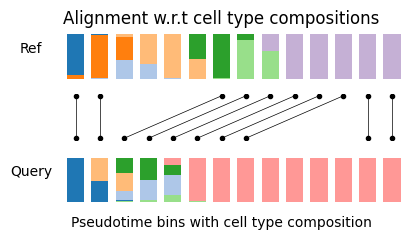

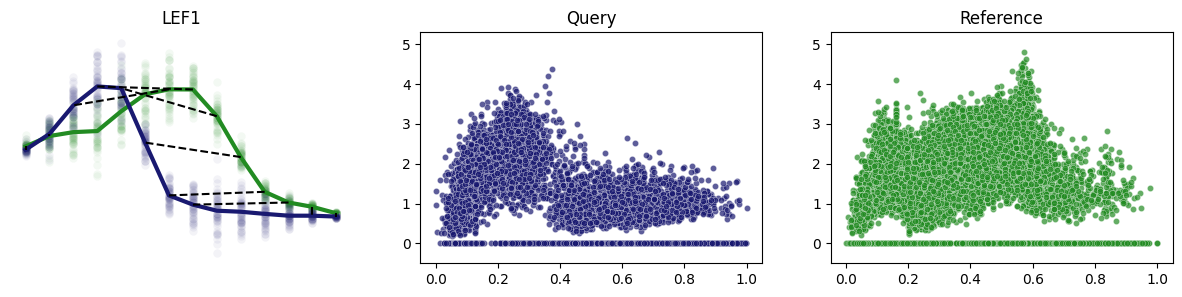

In [12]:
VisualUtils.show_gene_alignment('LEF1', aligner, vs, joint_cmap)

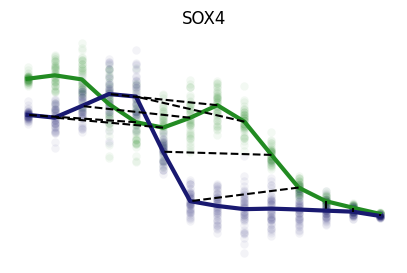

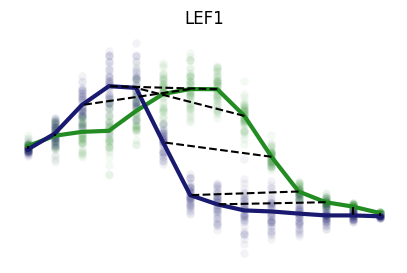

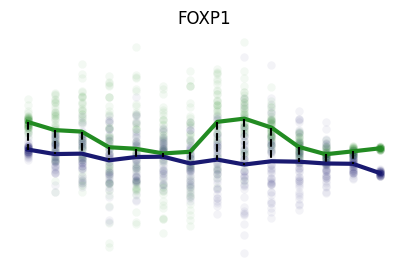

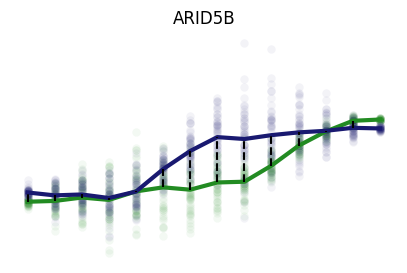

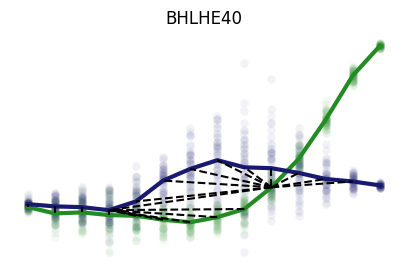

In [13]:
def plotTimeSeries(gene, refQueryAlignerObj, plot_mean_trend= False):
        al_obj = refQueryAlignerObj.results_map[gene]
        plt.subplots(1,1,figsize=(5,3))
        plotTimeSeriesAlignment(al_obj) 
        return 
            
def plotTimeSeriesAlignment(al_obj):  
        sb.scatterplot(x=al_obj.S.X, y=al_obj.S.Y, color = 'forestgreen' ,alpha=0.05, legend=False)#, label='Ref') 
        sb.scatterplot(x=al_obj.T.X, y=al_obj.T.Y, color = 'midnightblue' ,alpha=0.05, legend=False)#, label ='Query') 
        al_obj.S.plot_mean_trend(color='forestgreen')
        al_obj.T.plot_mean_trend(color='midnightblue')
        plt.title(al_obj.gene)# + str(al_obj.get_series_match_percentage()))
        plt.xlabel('pseudotime')
        plt.ylabel('log1p expression')
        plt.axis('off')
        
        for i in range(al_obj.matched_region_DE_info.shape[0]):
            S_timebin = int(al_obj.matched_region_DE_info.iloc[i]['ref_bin'])
            T_timebin = int(al_obj.matched_region_DE_info.iloc[i]['query_bin']) 
            x_vals = [al_obj.matched_region_DE_info.iloc[i]['ref_pseudotime'],al_obj.matched_region_DE_info.iloc[i]['query_pseudotime']] 
            y_vals = [al_obj.S.mean_trend[S_timebin ], al_obj.T.mean_trend[T_timebin]] 
            plt.plot(x_vals, y_vals, color='black', linestyle='dashed', linewidth=1.5)
            
plotTimeSeries('SOX4', aligner)
plt.savefig('MS_FIGS/RefATO/MoreFigs/SOX4.png',transparent=True)
plotTimeSeries('LEF1', aligner)
plt.savefig('MS_FIGS/RefATO/MoreFigs/LEF1.png',transparent=True)
plotTimeSeries('FOXP1', aligner)
plt.savefig('MS_FIGS/RefATO/MoreFigs/FOXP1.png',transparent=True)
plotTimeSeries('ARID5B', aligner)
plt.savefig('MS_FIGS/RefATO/MoreFigs/ARID5B.png',transparent=True)
plotTimeSeries('BHLHE40', aligner)
plt.savefig('MS_FIGS/RefATO/MoreFigs/BHLHE40.png',transparent=True)

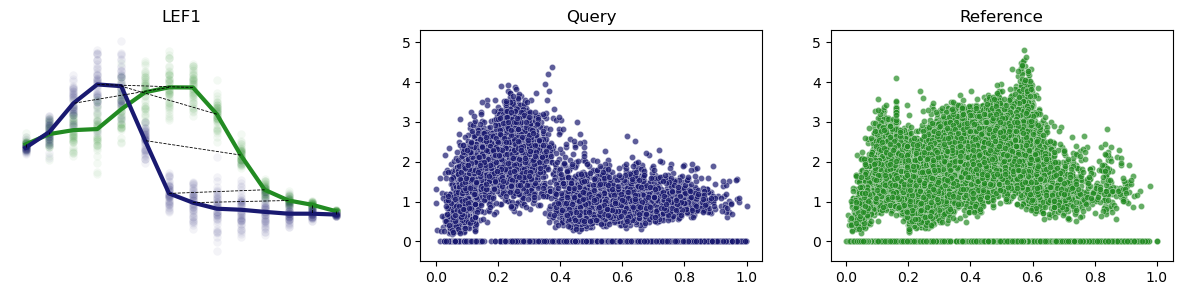

In [40]:
VisualUtils.plotTimeSeries('LEF1', aligner)

In [41]:
aligner.results_map['LEF1'].alignment_str

'MMDDDDMMMMMMIIIIMM'

In [ ]:
#pickle.dump(aligner, open('../GOOGLE_DRIVE_MOUNT/G2G_Analysis/G2G_paper_related/aligner_TF_CD8lineage.pkl', 'wb')) 

# Writing alignments to file

In [15]:
df = []
for g in aligner.gene_list:
    al_obj = aligner.results_map[g]
    df.append([g, al_obj.alignment_str, al_obj.get_series_match_percentage()[0]] )
df = pd.DataFrame(df)
df.columns = ['Gene','5-state alignment string','Alignment similarity %']
df


Gene 5-state alignment string  Alignment similarity %
0     AC023509.3     MMMMVVVVVVMMMMWWWWWW                  100.00
1     AC092835.1       MMMMMMMMMMVVVDDIDD                   72.22
2           ADNP      IIIDIMMMMMMMMMIDDDD                   47.37
3          ADNP2          MMMMMIMMMMMMMMD                   86.67
4          AEBP1        DDIDMMMMMMMIIMMMM                   64.71
...          ...                      ...                     ...
1215     ZSCAN5A           MMMMMMMMMMMMMM                  100.00
1216      ZSCAN9       MMMMMMMMMMIIDDIDID                   55.56
1217        ZXDA           MMMMMMMMMMMMMM                  100.00
1218        ZXDB          MMMMMMMMMMMMMID                   86.67
1219        ZXDC      IIIDMMMMMMMMMIIDDDD                   47.37

[1220 rows x 3 columns]

In [16]:
df.to_csv('results/G2G_SPT_DNonwards_alignments.csv')